In [3]:
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [31]:
I = 30          # iterations
N_PEDS = 50     # percentage of pedestrians
N_CARS = 50     # percentage of cars
MODEL = "new"  # type of the model ('base' or 'new')

base_folder = f"./data/{MODEL}"

exps = [
    #{ "N_PEDS": 0, "N_CARS": 100 },
    { "N_PEDS": 25, "N_CARS": 75 },
    { "N_PEDS": 50, "N_CARS": 50 },
    #{ "N_PEDS": 75, "N_CARS": 25 },
    #{ "N_PEDS": 100, "N_CARS": 0 },
]

## Percentage of Evacuated

In [39]:
total_dfs = []
cars_dfs = []
peds_dfs = []

for i in range(1, I + 1):
    data = pd.read_csv(f"{base_folder}/evacuated/evacuated-{N_PEDS}-{N_CARS}-{i}.csv", skiprows=18)

    tot_evac = data[['x', 'y']].copy()
    tot_evac["i"] = i
    #tot_evac["cat"] = "evacuated"

    cars_evac = data[['x.1', 'y.1']].copy()
    cars_evac["i"] = i
    #cars_evac["cat"] = "cars"
    #cars_evac = cars_evac.rename(columns={'x.1':'x', 'y.1':'y'})

    peds_evac = data[['x.2', 'y.2']].copy()
    peds_evac["i"] = i
    #peds_evac["cat"] = "pedestrians"
    #peds_evac = peds_evac.rename(columns={'x.2':'x', 'y.2':'y'})

    # xx = pd.concat([tot_evac, cars_evac, peds_evac])

    #total_dfs.append(xx)

    total_dfs.append(tot_evac)
    cars_dfs.append(cars_evac)
    peds_dfs.append(peds_evac)

t_df = pd.concat(total_dfs).reset_index() # drop=True
c_df = pd.concat(cars_dfs).reset_index()
p_df = pd.concat(peds_dfs).reset_index()

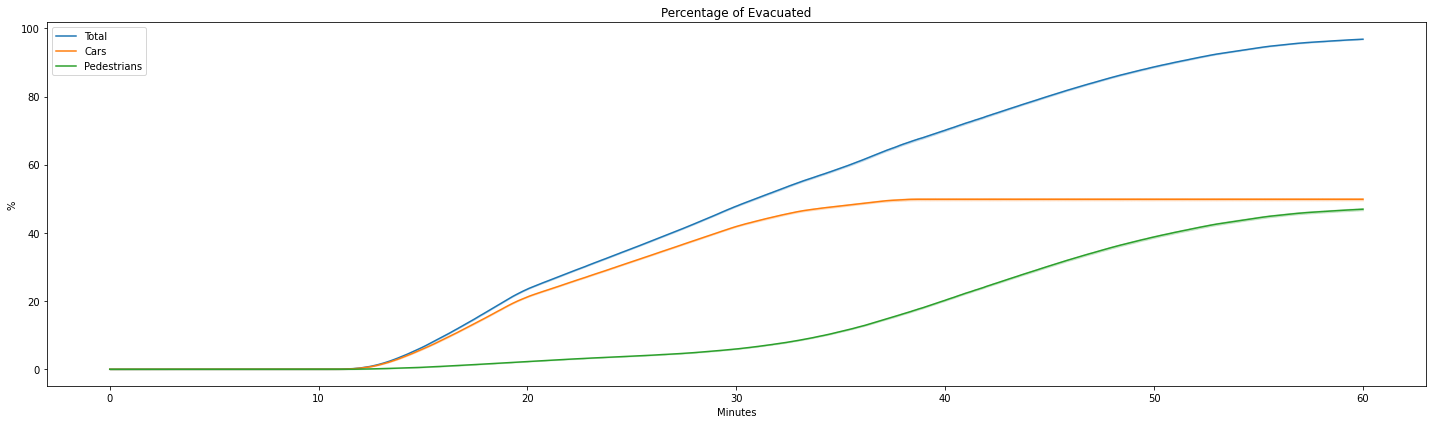

In [40]:
fig = plt.figure(figsize=(20, 6))
ax = sns.lineplot(x=t_df["x"], y=t_df["y"], label="Total") #  hue=t_df["cat"]
ax.set_title("Percentage of Evacuated")
ax.set_xlabel("Minutes")
ax.set_ylabel("%")
sns.lineplot(x=c_df["x.1"], y=c_df["y.1"], label="Cars")
sns.lineplot(x=p_df["x.2"], y=p_df["y.2"], label="Pedestrians")
fig.tight_layout()

# Casualties

In [150]:
total_dfs = []
cars_dfs = []
peds_dfs = []

for i in range(1, I + 1):
    data = pd.read_csv(f"{base_folder}/casualties/casualties-{N_PEDS}-{N_CARS}-{i}.csv", skiprows=18)

    tot_evac = data[['x', 'y']].copy()
    tot_evac["i"] = i
    #tot_evac["cat"] = "evacuated"

    cars_evac = data[['x.1', 'y.1']].copy()
    cars_evac["i"] = i
    #cars_evac["cat"] = "cars"
    #cars_evac = cars_evac.rename(columns={'x.1':'x', 'y.1':'y'})

    peds_evac = data[['x.2', 'y.2']].copy()
    peds_evac["i"] = i
    #peds_evac["cat"] = "pedestrians"
    #peds_evac = peds_evac.rename(columns={'x.2':'x', 'y.2':'y'})

    # xx = pd.concat([tot_evac, cars_evac, peds_evac])

    #total_dfs.append(xx)

    total_dfs.append(tot_evac)
    cars_dfs.append(cars_evac)
    peds_dfs.append(peds_evac)

t_df = pd.concat(total_dfs).reset_index() # drop=True
c_df = pd.concat(cars_dfs).reset_index()
p_df = pd.concat(peds_dfs).reset_index()

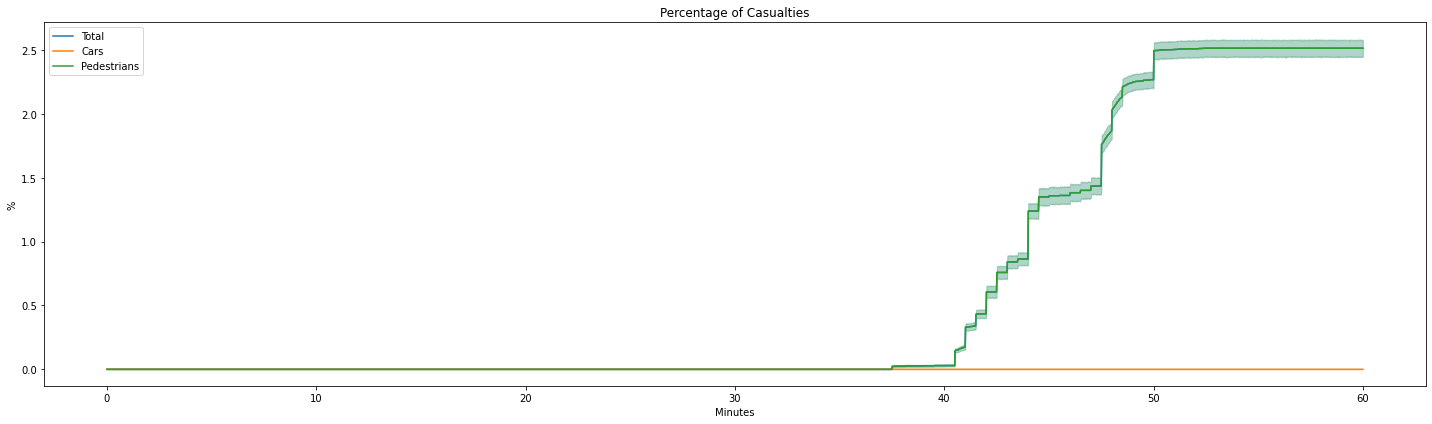

In [42]:
fig = plt.figure(figsize=(20, 6))
ax = sns.lineplot(x=t_df["x"], y=t_df["y"], label="Total") #  hue=t_df["cat"]
ax.set_title("Percentage of Casualties")
ax.set_xlabel("Minutes")
ax.set_ylabel("%")
sns.lineplot(x=c_df["x.1"], y=c_df["y.1"], label="Cars")
sns.lineplot(x=p_df["x.2"], y=p_df["y.2"], label="Pedestrians")
fig.tight_layout()

### Compare between configurations grouping by cars/pedestrias

In [32]:
def plot_comparisons(measure, normalize=True):
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharey=True, sharex=True)
    axes = axes.flatten()

    axes[0].set_title(f"Cars")
    axes[0].set_xlabel("Minutes")
    axes[0].set_ylabel(f"% {measure.capitalize()}")

    axes[1].set_title(f"Pedestrians")
    axes[1].set_xlabel("Minutes")
    axes[1].set_ylabel(f"% {measure.capitalize()}")

    for i, exp in enumerate(exps):
        avg_data = pd.DataFrame()
        for k in range(1, I + 1):
            data = pd.read_csv(f"{base_folder}/{measure}/{measure}-{exp['N_PEDS']}-{exp['N_CARS']}-{k}.csv", skiprows=18)
            data["i"] = k

            avg_data = pd.concat((data, avg_data))

        groups = avg_data.groupby(avg_data.index)
        cars_avg_data = groups[["x.1", "y.1"]].mean()
        peds_avg_data = groups[["x.2", "y.2"]].mean()

        # normalize 
        if normalize:
            cars_avg_data["y.1"] = cars_avg_data["y.1"] * exp['N_CARS'] / 100
            peds_avg_data["y.2"] = peds_avg_data["y.2"] * exp['N_PEDS'] / 100

        lbl = f"Pedestrians: {exp['N_PEDS']}%, Cars: {exp['N_CARS']}%"
        
        sns.lineplot(x=cars_avg_data["x.1"], y=cars_avg_data["y.1"], ax=axes[0], label=lbl)
        sns.lineplot(x=peds_avg_data["x.2"], y=peds_avg_data["y.2"], ax=axes[1], label=lbl)

    fig.tight_layout()

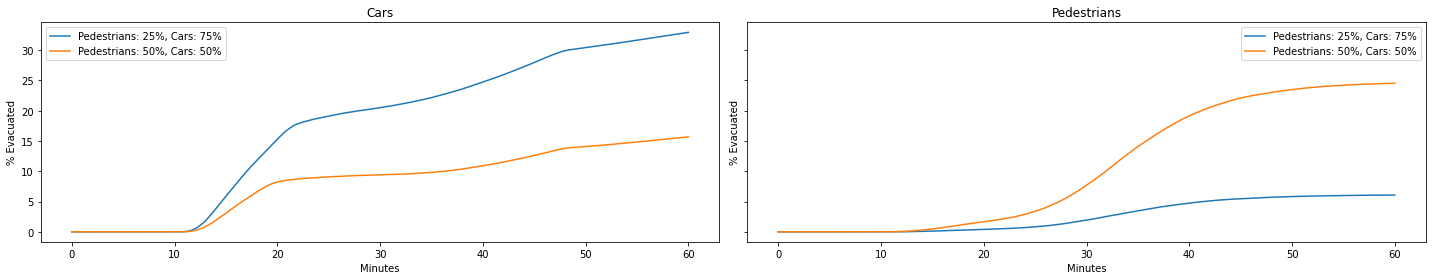

In [33]:
plot_comparisons("evacuated")

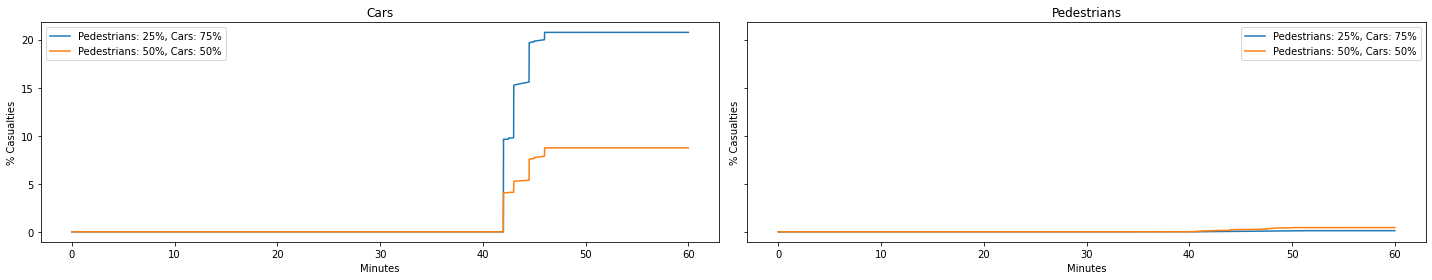

In [34]:
plot_comparisons("casualties")

## Evacuation Times

In [43]:
# averaged times
df = pd.DataFrame({"y" : [0] * 60}, index=range(1, 61))

for i in range(1, I + 1):
    data = pd.read_csv(f"{base_folder}/times/times-{N_PEDS}-{N_CARS}-{i}.csv", skiprows=18)
    data = data[['x', 'y']].set_index("x")
    data = data.reindex(range(1, 61), fill_value=0)
    df = df + data

df = df / I
df = df.reset_index()
df.columns=["x", "y"]

In [44]:
# confidence interval
df = []
for i in range(1, I + 1):
    data = pd.read_csv(f"{base_folder}/times/times-{N_PEDS}-{N_CARS}-{i}.csv", skiprows=18)
    data = data[['x', 'y']].set_index("x")
    data['i'] = i
    data = data.reindex(range(1, 61), fill_value=0)
    df.append(data)
    
df = pd.concat(df).reset_index()

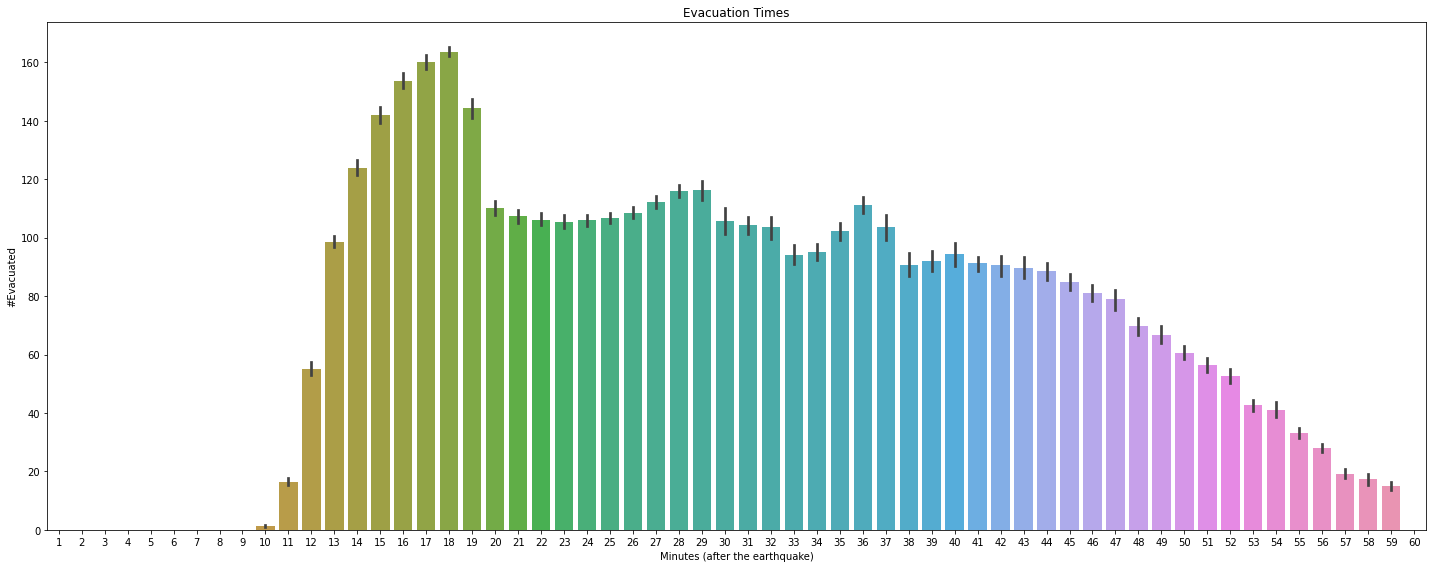

In [45]:
fig = plt.figure(figsize=(20, 8))
ax = sns.barplot(x=df['x'], y=df['y'])
ax.set_title("Evacuation Times")
ax.set_xlabel("Minutes (after the earthquake)")
ax.set_ylabel("#Evacuated")
fig.tight_layout()

In [35]:
from pickletools import uint8


def plot_comparisons_evtimes(normalize=True):
    fig, ax = plt.subplots(len(exps), 1, figsize=(20, 10), sharex=True, sharey=True)
    ax = ax.flatten()

    for i, exp in enumerate(exps):
        
        avg_data = None
        for k in range(1, I + 1):
            data = pd.read_csv(f"{base_folder}/times/times-{exp['N_PEDS']}-{exp['N_CARS']}-{k}.csv", skiprows=18)
            data = data[['x', 'y']].set_index("x")
            data = data.reindex(range(1, 61), fill_value=0)
            data = data.reset_index()
            
            if avg_data is None:
                avg_data = data
            else:
                avg_data = pd.concat((avg_data, data))

        groups = avg_data.groupby(avg_data.index)
        avg_evtimes_data = groups[["x", "y"]].mean()

        lbl = f"Pedestrians: {exp['N_PEDS']}%, Cars: {exp['N_CARS']}%"
        
        avg_evtimes_data["x"] = avg_evtimes_data["x"].astype(np.uint8)
        sns.barplot(x=avg_evtimes_data["x"], y=avg_evtimes_data["y"], ax=ax[i],)
        ax[i].set_title(lbl)
        ax[i].set_xlabel("Minutes (after the earthquake)")
        ax[i].set_ylabel("#Evacuated")

    fig.tight_layout()

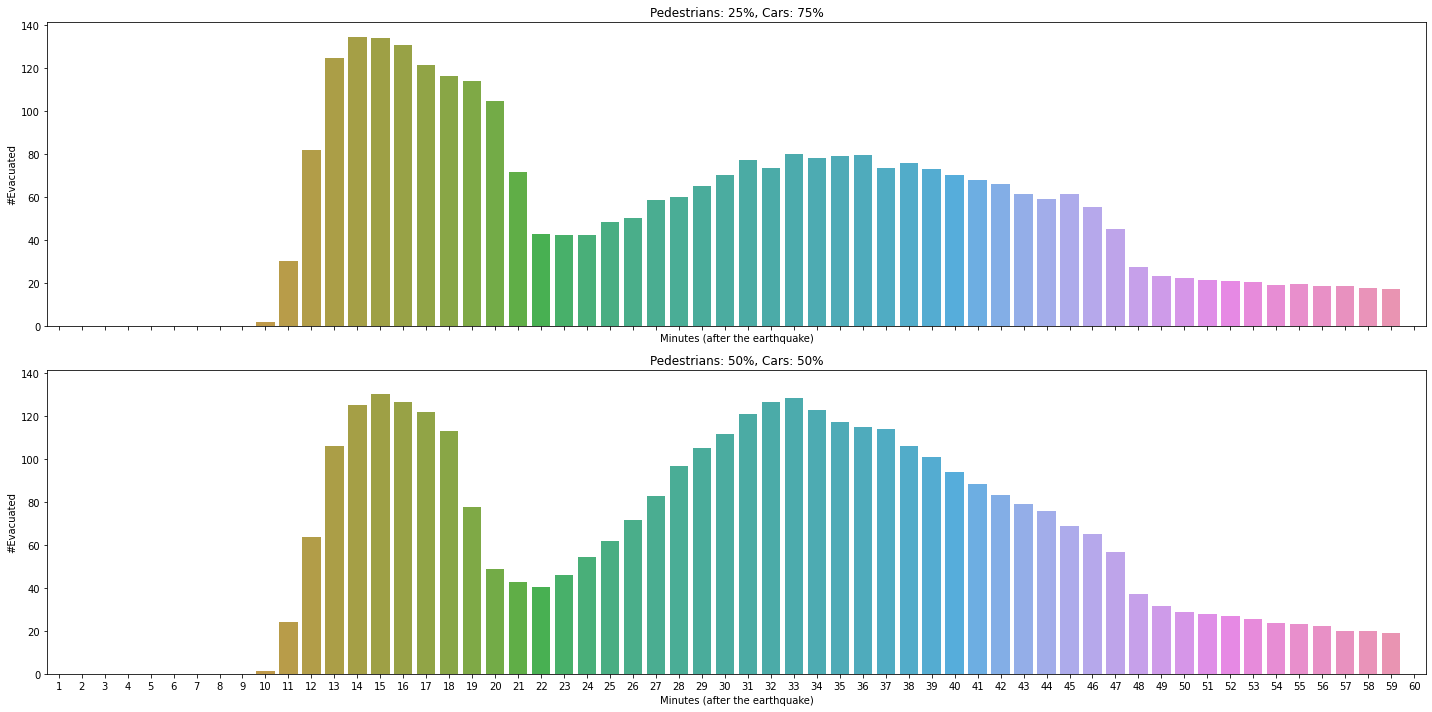

In [36]:
plot_comparisons_evtimes()

## Network Data

### Average Values

In [46]:
import re

LIST_RE = re.compile(r"\[(\d+) (\d+(?:\.\d+)?)\]")


def parse_list(netlogo_list):
    x = LIST_RE.findall(netlogo_list)
    x = dict(map(list, x))

    return x


def to_netlogo(value):
    return "[" + " ".join([f"[{k} {v}]" for (k, v) in value.items()]) + "]" 


def average_netlogo_lists(lists):
    lists = list(map(parse_list, lists))
    
    # append values of the same intersection
    new_dict = {}
    for n in lists:
        for (key, value) in n.items():
            if key not in new_dict:
                new_dict[key] = []

            new_dict[key].append(float(value))

    # pad values if missing and replace values with the mean
    for (key, value) in new_dict.items():
        new_dict[key] = np.mean((np.pad(value, (0, I - len(value)))))

    return to_netlogo(new_dict)

In [47]:
prefix = f"{base_folder}/intersections/intersections-{N_PEDS}-{N_CARS}"

ints_df = None
for i in range (1, I + 1):
    data = pd.read_csv(f"{prefix}-{i}.csv")
    data = data.set_index(["who", "minute"])

    ints_df = pd.concat((ints_df, data))

grouped_ints_df = ints_df.groupby(level=[0, 1])

# average values 

avg_ints_df = pd.DataFrame(grouped_ints_df["car-delay"].mean())

for col in set(ints_df.columns) - set(["car-delay"]):
    avg_list = grouped_ints_df[col].apply(lambda x: average_netlogo_lists(x))
    avg_ints_df = avg_ints_df.join(avg_list)

avg_ints_df.to_csv(f"{prefix}-mean.csv")

In [48]:
prefix = f"{base_folder}/intersections/intersections-evtimes-{N_PEDS}-{N_CARS}"

ints_evtime_df = None
for i in range (1, I + 1):
    data = pd.read_csv(f"{prefix}-{i}.csv")
    data = data.set_index(["who"])

    ints_evtime_df = pd.concat((ints_evtime_df, data))

ints_evtime_df = ints_evtime_df.groupby(level=[0]).mean()
ints_evtime_df.to_csv(f"{prefix}-mean.csv")

In [49]:
prefix = f"{base_folder}/roads/roads-{N_PEDS}-{N_CARS}"

roads_df = None
for i in range (1, I + 1):
    data = pd.read_csv(f"{prefix}-{i}.csv")
    data = data.set_index(["end1", "end2", "minute"])

    roads_df = pd.concat((roads_df, data))

roads_df = roads_df.groupby(level=[0, 1, 2]).mean()

roads_df.to_csv(f"{prefix}-mean.csv")

### Casualties

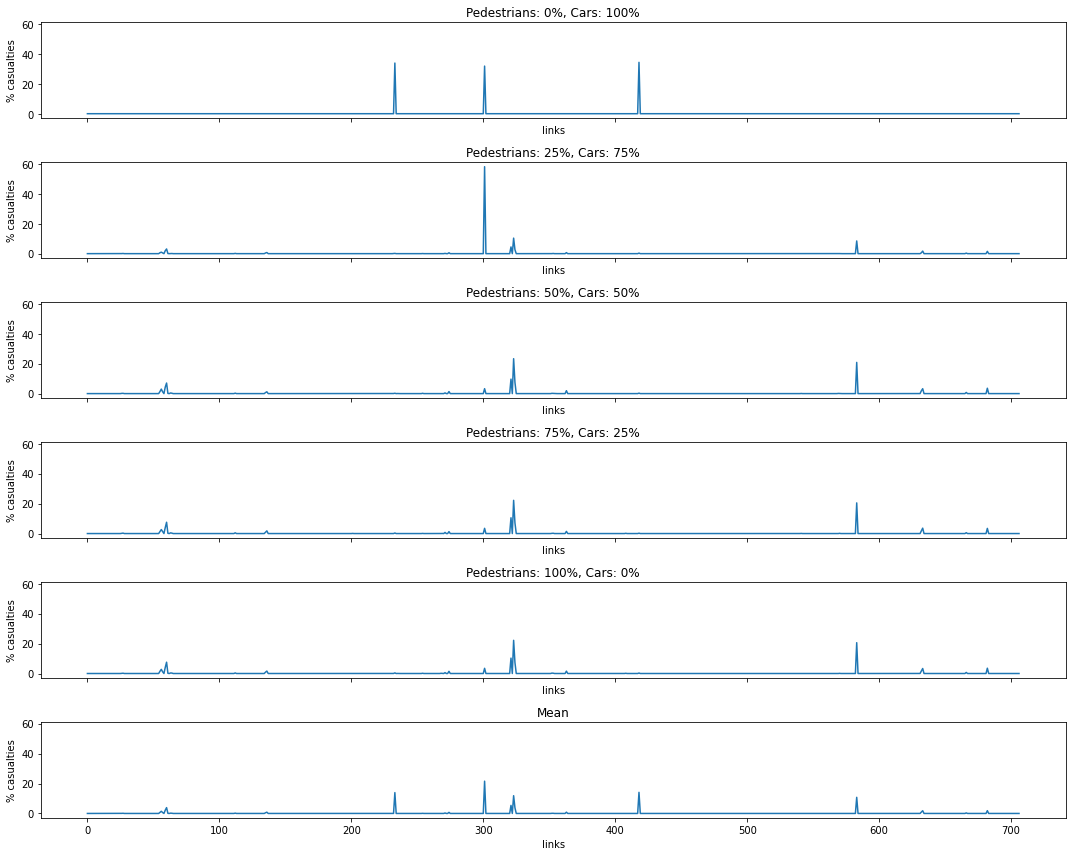

In [50]:
fig, ax = plt.subplots(len(exps) + 1, 1, figsize=(15, 12), sharex=True, sharey=True)

avg_casualties = []
for i in range(len(exps) + 1):
    if i < len(exps):
        exp = exps[i]
        data = pd.read_csv(f"{base_folder}/roads/roads-{exp['N_PEDS']}-{exp['N_CARS']}-mean.csv")

        ints1 = set(data["end1"]) 
        ints2 = set(data["end2"])

        data = data.set_index(["end1", "end2"])
        data = data.loc[data["minute"] == 60]

        for x in ints1:
            for y in ints2:   
                if (x, y) in data.index and (y, x) in data.index:
                    data.loc[(x, y)] = data.loc[(x, y)] + data.loc[(y, x)]
                    data.drop((y, x), inplace=True)

        data = data.reset_index()

        casualties = data["casualties"]
        avg_casualties.append(casualties)

        ax[i].set_title(f"Pedestrians: {exp['N_PEDS']}%, Cars: {exp['N_CARS']}%")
    else:
        casualties = np.mean(avg_casualties, axis=0)
        ax[i].set_title(f"Mean")

    ax[i].set_ylabel("% casualties")
    ax[i].set_xlabel("links")
    sns.lineplot(casualties / np.sum(casualties) * 100, ax=ax[i])

fig.tight_layout()